# TP1 - IA
Détection d'incendie à partie d'images satellites hyper-spectrales

#### Next cell must be executed only if the Notebook file has been downloaded from the github/gitlab repos

Mount your Google Drive to Colab,
Clone the github repository,
Go in the github directory,
Download and extract the Dataset (localy on the Colab virtual machine)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB == True:
    from google.colab import drive

    drive.mount("/content/gdrive")

    %cd /content/gdrive/MyDrive

    # if TP_wildfire_segmentation_ETU folder doesn't exist then clone the github project in /content/gdrive/MyDrive
    ! [ ! -d TP_wildfire_segmentation_ETU ] && git clone "https://github.com/ThomasLOUIS1/TP_wildfire_segmentation_ETU.git"

    # Go to the github project folder
    %cd /content/gdrive/MyDrive/TP_wildfire_segmentation_ETU/data

    # if dataset.zip dosn't exist then download it
    ! [ ! -f dataset.zip ] && echo "dataset.zip dosn't exist" && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS" -O dataset.zip && rm -rf /tmp/cookies.txt

    # if sample_data/RGB dosn't exist then exctract the dataset into sample_data/
    ! [ ! -d /content/sample_data/RGB ] && echo "data dosn't exist" && unzip -qq dataset.zip -d /content/sample_data

    data_dir = "/content/sample_data"

    %cd /content/gdrive/MyDrive/TP_wildfire_segmentation_ETU
else :
    # if dataset.zip dosn't exist then download it
    ! [ ! -f data/dataset.zip ] && echo "dataset.zip doesn't exist" && wget -P data/ --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1idUH24mGyAegB0YzDcJmd9XyNVbqGsnS" -O dataset.zip && rm -rf /tmp/cookies.txt

    # if data/RGB dosn't exist then exctract the dataset into data/
    ! [ ! -d data/RGB ] && echo "data doesn't exist" && unzip -qq data/dataset.zip -d data/

    data_dir = "data/"

    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive
/content/gdrive/MyDrive/TP_wildfire_segmentation_ETU/data
/content/gdrive/MyDrive/TP_wildfire_segmentation_ETU


# Wildfire detection (Segmentation) with Multi-spectral Images

### What is Image Segmentation ?

Image Segmentation is the process of dividing an image into multiple segments or regions, each of which corresponds to a different object or part of the image.

For example, in fire segmentation, the goal is to identify and segment the regions of fire in a video or an image. The segmented fire pixels can then be used to detect the extent and spread of the fire. This information can be useful for fire-fighters to respond to emergency situations more effectively.

### What are multi-spectrale Images and why using it for Wildfire Segmentation ?

Multi-spectral images are images representing the same area in multiple wavelength band. They are very useful for wildfire segmentation because they can provide more information about the characteristics of the wildfire and the surrounding area than RGB images.

For example, near-infrared (NIR) bands can be used to identify vegetation, while shortwave infrared (SWIR) bands can be used to detect the presence of smoke. Additionally, using multiple wavelength bands can help to reduce the impact of atmospheric conditions such as clouds and haze on the image. This can improve the accuracy of the segmentation task and make it easier to identify a wildfire in the image.

These images are stored in `.tif files`. TIFF is a widely-used file format for images. It is capable of storing images in a lossless format, meaning that no data is lost when the image is compressed. This makes it a popular choice for storing high-quality images, such as those used in professional photography, printing or satellite imagery.

# 0.1 Get dataset files paths

Loading a segmentation dataset differ from loading a classification dataset with a tensorflow or Keras function. When using Keras for MNIST for example, images are stored in folder correspondign to a class. In folder 0, there are all images for the number 0.

Here, we will not load data from classes since data do not belong to any classes. The segmentation task will generate a mask (having the same size as the input image) and each pixel of the mask is a value 0 or 1 corresponding to the fire/notfire class.

In [ ]:
# Imports
import os
import PIL
from PIL import Image
import tensorflow as tf


######################################
# Complete the folowing code replacing "______" :
######################################
# Dataset folder paths declaration
RGB_dir = data_dir + "/RGB"                    # Only for display purpose
triband_dir = data_dir + "/tribands"    # Data directory
mask_dir = data_dir + "/masks"          # Labels directory

# Define images size
img_size = (256,256)

######################################
######################################

######################################
# What's the purpose of the following function ?
# Answer : ___________________________________.
def sort_tif_paths_from_folder(dir):
    """
    Get all tif files sorted by name in a directory and return as a sorted list.

    Parameters:
    dir (str): directory path containing the tif files

    Returns:
    list: sorted list of tif file paths in the directory
    """
    paths_list = sorted(
    [
        os.path.join(dir, fname)
        for fname in os.listdir(dir)
        if fname.endswith(".tif")
    ]
    )
    return paths_list
######################################
######################################

# Get sorted list of tif files for RGB images
RGB_img_paths = sort_tif_paths_from_folder(RGB_dir)

######################################
# Complete the folowing code replacing "______" :
######################################
# Get sorted list of tif files for triband training images
triband_img_paths_train = sort_tif_paths_from_folder(triband_dir + "/train" )
# Get sorted list of tif files for triband validation images
triband_img_paths_val = sort_tif_paths_from_folder(triband_dir + "/val")
# Get sorted list of tif files for triband test images
triband_img_paths_test = sort_tif_paths_from_folder(triband_dir + "/test")

# Get sorted list of tif files for mask training images
mask_img_paths_train = sort_tif_paths_from_folder(mask_dir + "/train")
# Get sorted list of tif files for mask validation images
mask_img_paths_val = sort_tif_paths_from_folder(mask_dir + "/val")
# Get sorted list of tif files for mask test images
mask_img_paths_test = sort_tif_paths_from_folder(mask_dir + "/test")
######################################
######################################

######################################
# Complete the folowing code replacing "______" :
# The idea is to compute the number of samples we have.
# Tips : you have to sum the length of triband_img_paths_train, triband_img_paths_val and triband_img_paths_test arrays
######################################
print("Number of samples from {} : {}".format(triband_dir,len(triband_img_paths_train+triband_img_paths_val+triband_img_paths_test)))
print("Number of samples from {} : {}".format(mask_dir,len(mask_img_paths_test+mask_img_paths_train+mask_img_paths_val)))
######################################
######################################

# Print 6 firsts paths from RGB, biband and mask paths
# Note: Only works for the first 15 because we don't have many RGB images
for RGB_path, triband_path, mask_path in zip(RGB_img_paths[:6], triband_img_paths_train[:6], mask_img_paths_train[:6]):
    print(RGB_path, "|", triband_path, "|", mask_path)


# 0.2 Let us visualize RGB / Tri-bands / mask datas

First let us import a function to display several images (declared in /utils.py) and others utils

In [3]:
# Display 1 or more numpy matrix
from utils import display_matrix

# Used to load/Read/ and plot images
import matplotlib.pyplot as plt

# Used to perform manipulation on matrix/images
import numpy as np


### Dataset Visualization

Let us visualize RBG and tri-bands image as well as the ground thruth mask.

You will see that with the RGB image, it's very difficult to see the fire... But with the tri-bands image, it's much more easier !

Image n 9, path : /content/sample_data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_5.tif


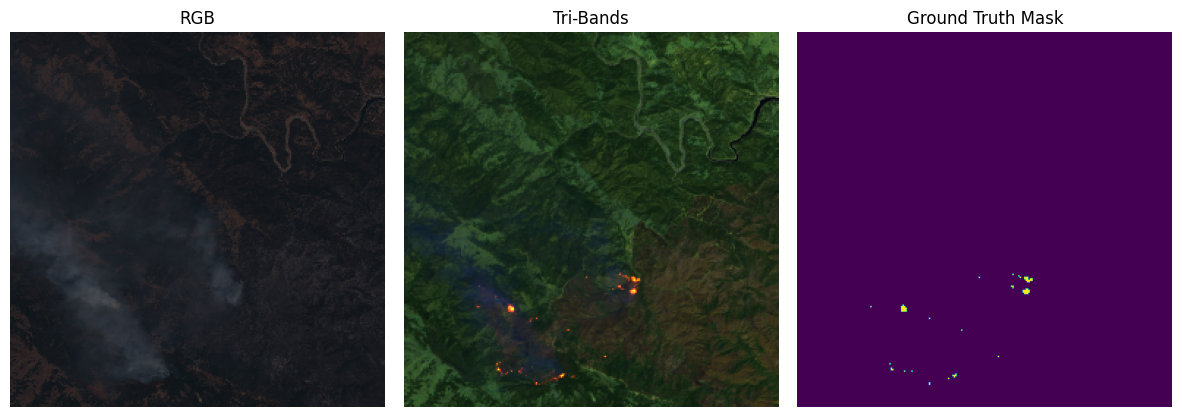

Image n 10, path : /content/sample_data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_6.tif


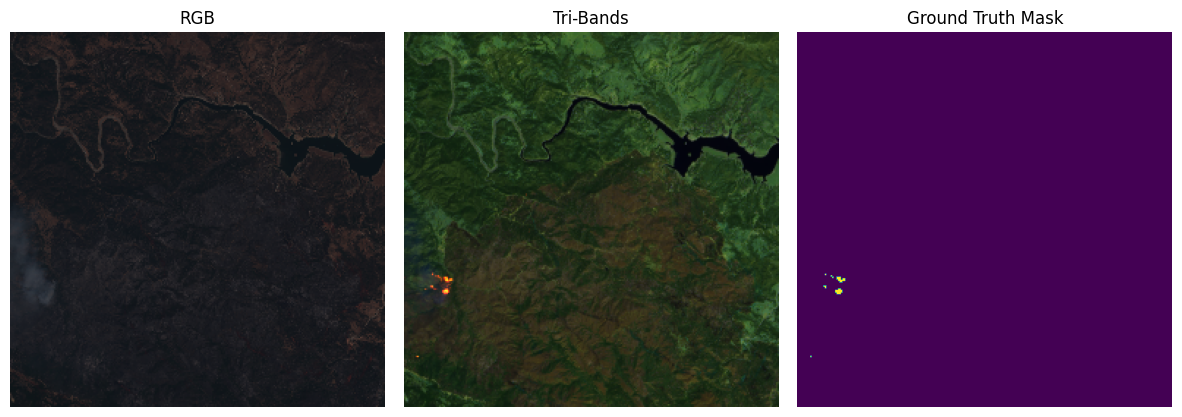

Image n 11, path : /content/sample_data/RGB/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_7.tif


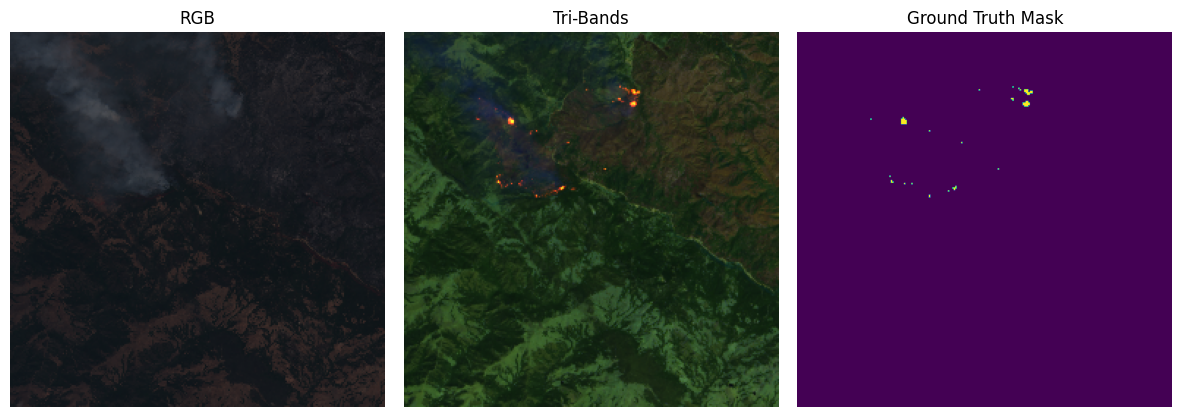

In [4]:
i = 0
n_images_to_display = 3
for id in range(len(RGB_img_paths)):
    # Read the mask data for the current iteration
    image_masks = Image.open(mask_img_paths_train[id])
    # Check if there's at least one "Fire" pixel and if the number of images displayed is less than 3

    if np.max(image_masks) > 0 and i < n_images_to_display:
        # Read RGB and Tri-bands data
        image_RGB = Image.open(RGB_img_paths[id])
        image_triband = Image.open(triband_img_paths_train[id])

        # print id and path of the associated RGB path
        print("Image n {}, path : {}".format(id, RGB_img_paths[id]))

        # Store data in matrix and display it
        matrix = [[image_RGB, image_triband, image_masks]]
        display_matrix(matrix, title_list=["RGB", "Tri-Bands", "Ground Truth Mask"])

        # Increment counter for number of images displayed
        i += 1

    # Break out of loop if 3 images have been displayed
    if i == n_images_to_display:
        break

### <font color="red">What do you think of Tribands images compared to RGB images ?</font>

**Put your answer bellow** :

C'est plus simple de distinguer le feu sur une image triband plutot que sur une image rgb

# 0.3 Load dataset

We will now load the dataset to use it later for training.

First we define a function to create a dataset from paths gathered previously.

In [5]:
batch_size = 16
######################################
# Complete the following code replacing "______" :
######################################
def load_triband_and_mask_from_paths(paths = None):
    """
    Load the tri-bands and mask images data from the given paths and convert them into a tensorflow dataset.

    Parameters:
    paths (List): List of tuples of tri-bands and mask image paths

    Returns:
    data (tf.data.Dataset): A tensorflow dataset object with tri-bands and mask images data.
    """

    # Initialize arrays to store tri-bands image data and mask image data
    x = np.zeros((len(paths),) + img_size + (3,), dtype="float32")
    y = np.zeros((len(paths),) + img_size + (1,), dtype="float32")

    # Loop through the list of tri-bands and mask image paths
    for i, (triband_path, mask_path)  in enumerate(paths):

        # Read the tri-bands image file and normalize the data
        triband = np.array(Image.open(triband_path)) /255

        # Open the mask image file
        mask = np.array(Image.open(mask_path))
        # Add an extra dimension to the mask data for compatibility with the model
        mask = np.expand_dims(mask, 2) # same as np.reshape(mask, (256,256,1))
        y[i] = mask

    # Create a tensorflow dataset from tri-bands and mask image data
    data = tf.data.Dataset.from_tensor_slices((x, y))

    # Batch the dataset and fetch the data in advance for faster processing
    data = data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return data
######################################
######################################

And we use it to load train, val and test sets

In [6]:
# Create tuples of (Tri-bands image path, mask image path) for train, val and test datasets
train_paths = list(zip(triband_img_paths_train, mask_img_paths_train))
val_paths = list(zip(triband_img_paths_val, mask_img_paths_val))
test_paths = list(zip(triband_img_paths_test, mask_img_paths_test))


######################################
# Complete the folowing code replacing "______" :
######################################
# Load train, val and test datasets from the tuple of Tri-bands and mask image paths
train_ds =  load_triband_and_mask_from_paths(train_paths)
val_ds = load_triband_and_mask_from_paths(val_paths)
test_ds = load_triband_and_mask_from_paths(test_paths)
######################################
######################################

# 1.0 Let us Build the CNN model for image segmentation

Here we will create a very classical [Unet-like CNN model](https://medium.com/analytics-vidhya/what-is-unet-157314c87634) that we'll be used for each training.

### <font color="red">Create the Unet-like CNN model with the following architecture : </font>
1. A **2D convolution** (`Conv2D`) with 8 filters of 3*3 and a ReLU activation
2. A **Max Pooling 2D** with 2*2 kernel
---
3. A **2D convolution** with 4 filters of 3*3 and a ReLU activation
---
4. A **Dropout** layer at 25%
---
5. A **2D Transpose Convolution** (`Conv2DTranspose`) with 4 filters of 3*3 and a ReLU activation
6. A **Up Sampling 2D** (`UpSampling2D`) with 2*2 kernel
---
7. A **2D Transpose Convolution** with 8 filters of 3*3 and a ReLU activation
---
8. A **2D Convolution** with 1 filter of 3*3, a Sigmoid activation with a same padding

At the end display the model.

In [7]:
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam

In [8]:
######################################
# Complete the code with the architecture of the model described above :
######################################

model = Sequential()

model.add(Input((256,256,3)))
model.add(Conv2D(8,(3,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(4,(3,3)))
model.add(Dropout(0,25))
model.add(Conv2DTranspose(4,(3,3)))
model.add(UpSampling2D((2,2)))
model.add(Conv2DTranspose(8,(3,3)))
model.add(Conv2D(1,(3,3),activation='sigmoid', padding='same'))




######################################
######################################

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 4)       292       
                                                                 
 dropout (Dropout)           (None, 125, 125, 4)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 127, 127, 4)       148       
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 254, 254, 4)       0

# 1.1 Clone the 1st model

Let us clone this model into a new "model1". By doing that, we will be able to perform different trainings with the same starting model.

In [9]:
from tensorflow.keras.models import clone_model

model1 = clone_model(model)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 4)       292       
                                                                 
 dropout (Dropout)           (None, 125, 125, 4)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 127, 127, 4)       148       
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 254, 254, 4)       0

### <font color="red"> Compile the model with the following parameters : </font>
 - An Adam optimizer with a learning rate at 0.01
 - A Binary Accuracy metrics
 - A Binary Crossentropy loss

Add Optimizer, Metric(s), Loss(es) and compile the model1

In [10]:
from tensorflow.keras.optimizers import Adam
######################################
# Complete the folowing code replacing "______" :
######################################

model1.compile(optimizer =Adam(learning_rate=0.01) , metrics = 'binary_accuracy', loss ='binary_crossentropy')

######################################
######################################

# 1.2 Train the model1

Now we will train the model1 for 4 epochs with "train_ds" dataset for trainong and "val_ds" for validation.

In [11]:
######################################
# Complete the folowing code replacing "______" :
######################################

history = model1.fit(train_ds, epochs = 4, validation_data = val_ds)

######################################
######################################

Epoch 1/4
64/64 [==============================] - 13s 76ms/step - loss: 0.0586 - binary_accuracy: 0.9982 - val_loss: 0.0135 - val_binary_accuracy: 0.9987
Epoch 2/4
64/64 [==============================] - 2s 34ms/step - loss: 0.0174 - binary_accuracy: 0.9982 - val_loss: 0.0118 - val_binary_accuracy: 0.9987
Epoch 3/4
64/64 [==============================] - 2s 28ms/step - loss: 0.0161 - binary_accuracy: 0.9982 - val_loss: 0.0108 - val_binary_accuracy: 0.9987
Epoch 4/4
64/64 [==============================] - 2s 31ms/step - loss: 0.0148 - binary_accuracy: 0.9982 - val_loss: 0.0106 - val_binary_accuracy: 0.9987


Let us evaluate the model1 with the test dataset (test_ds)

In [12]:
# Import a function that display scores and values (see utils.py)
from utils import print_score

######################################
# Complete the folowing code replacing "______" :
######################################

model1_score = model1.evaluate(test_ds)

######################################
######################################

# Display model1 scores
print_score(model1_score)

21/21 [==============================] - 1s 20ms/step - loss: 0.0132 - binary_accuracy: 0.9984
|loss: 1.32%|	|Accuracy: 99.84%|	

### <font color="red">What do you think of the model1 scores ?</font>

**Put your answer bellow** :

le score du model est bon: 2.69% de loss et 99.84% d'accuracy


# But, is this score really accurate ?

Let's check this score with diplaying some prediction from the test set...

Image n 2, path : /content/sample_data/tribands/test/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_6.tif


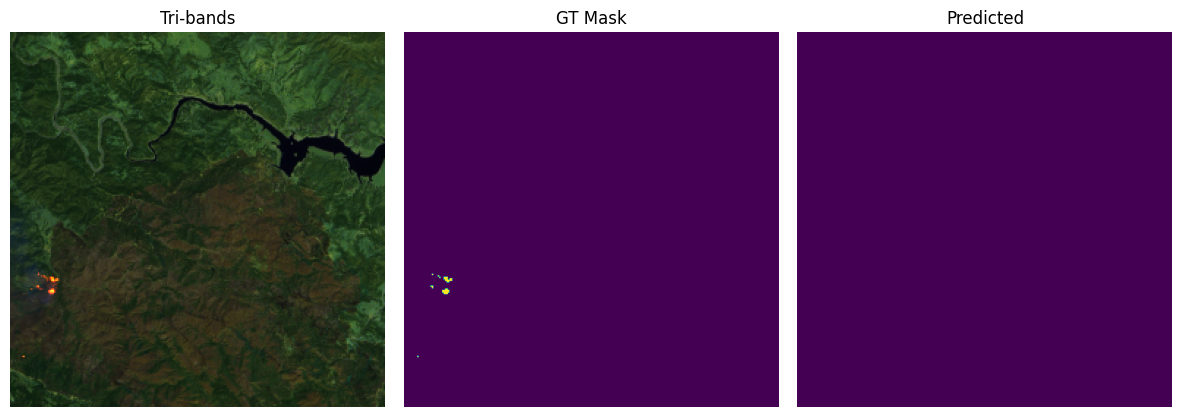

Image n 4, path : /content/sample_data/tribands/test/_Sentinel-2 L1C from 2016-09-25_Cloverdale_BANDS-S2-L1C_0_1.tif


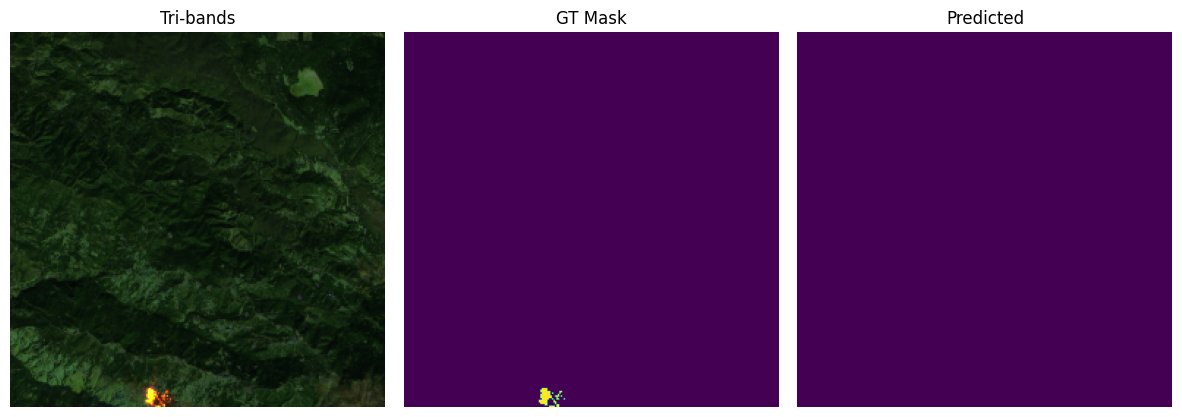

Image n 5, path : /content/sample_data/tribands/test/_Sentinel-2 L1C from 2017-07-24_ProençaANova_BANDS-S2-L1C_0_8.tif


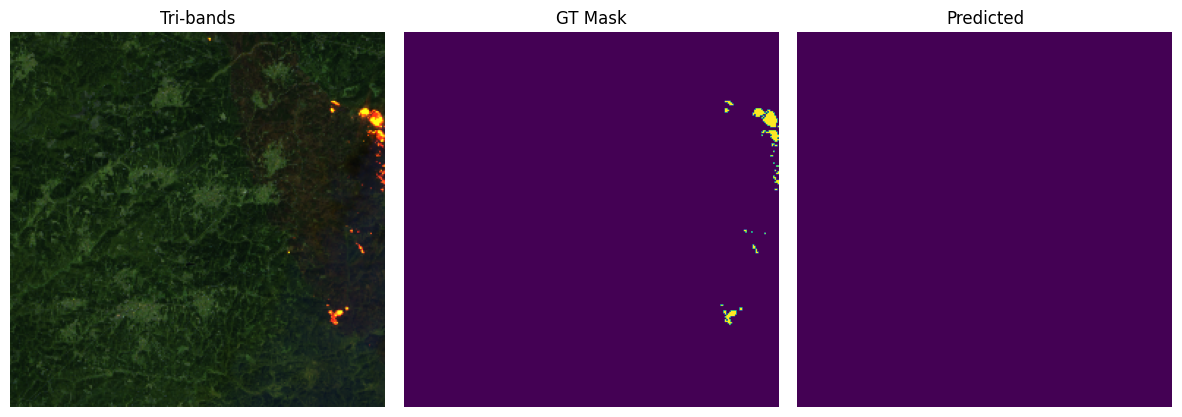

In [13]:
# Import a predict function similar to model.predict but with a treshhold at 0.5 (see utils.py)
from utils import predict

# A function that display firsts n_range tri-bands, masks and predictions
def display_sample_prediction(model, triband_paths, mask_paths, n_range = 3):
  # Pass through n_range firsts images
  i = 0
  for id in range(len(triband_paths)):
    # Read the mask data for the current iteration
    image_masks = Image.open(mask_paths[id])
    # Check if there's at least one "Fire" pixel and if the number of images displayed is less than n_range

    if np.max(image_masks) > 0 and i < n_range:

      # Read and normalize triband
      n_triband = np.array(Image.open(triband_paths[id]))/255.0

      # Add an extra dimension to the triband data for compatibility with the model input
      tribands = np.expand_dims(n_triband, 0) # Same as np.reshape(tribands, (1,256,256,3))

      # print id and path of the associated Tri-bands path
      print("Image n {}, path : {}".format(id, triband_paths[id]))

      predicted_mask = predict(model, tribands)
      predicted_mask = np.squeeze(predicted_mask)

      matrix=[[n_triband, image_masks, predicted_mask]] # [[Tribands,mask,predict]]

      display_matrix(matrix ,title_list=['Tri-bands', 'GT Mask', 'Predicted'])

      # Increment counter for number of images displayed
      i += 1

    # Break out of loop if n_range images have been displayed
    if i == n_range:
        break

######################################
# Complete the folowing code replacing "______" :
######################################

# Diplay Tri-bands, mask and prediction of the model1
display_sample_prediction(model1, triband_img_paths_test, mask_img_paths_test)

######################################
######################################


### <font color="red">What do you think of the Predictions compared to the Masks ?</font>

**Put your answer bellow** :

La prediction n'est pas precise car il est prédit qu'il n'y a pas de feu or, il y a bien du feu

### The effect of an unbalanced dataset

The problem comes from the fact that there are more "No_fire" pixels than "Fire" pixels, much much more.

As a consequence, the neural network neglicts these "Fire" pixels, and will classify all pixels as "No_fire"...

We can see it with a Confusion Matrix

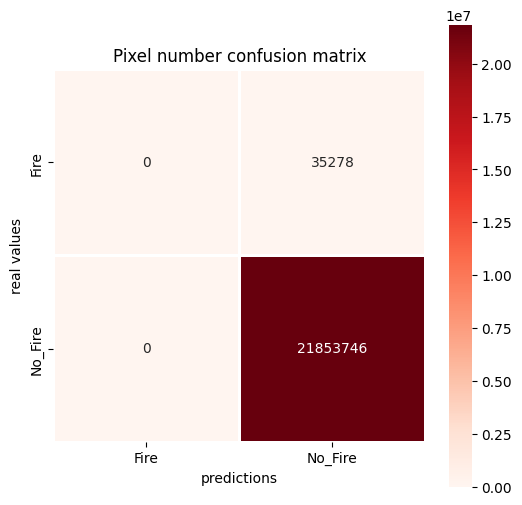

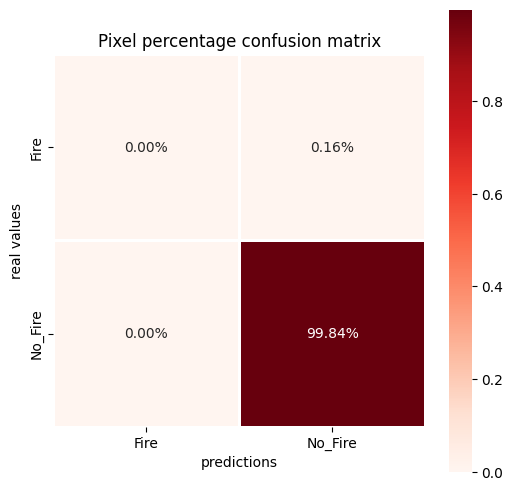

In [14]:
from utils import display_confusion_matrix, load_masks

test_gt_masks = load_masks(mask_img_paths_test, img_size=img_size)

display_confusion_matrix(predict(model1, test_ds), test_gt_masks)

### <font color="red">Compute Precision and Recall ?</font>

**Put your answer bellow** :

Le recall est ce qui est juste sur toute la base de donnée de feu, la precision est la ou on verifie le nombre de fois ou on a dit que quelque chose etait juste lorsqu'il etait reellement juste.

# 1.3 Dataset balancing

There are several ways to prevent bad generalization from an unbalanced dataset such as :

 - Resampling techniques such as oversampling the minority class or undersampling the majority class to balance the dataset.
 - Collecting more data to balance the classes or using a different dataset.

In our case, the simpliest way is to use a **weighted loss function** to give more importance to the minority class (here Fire) during training.

On the top of that we will also use more metrics to see if the "Fire" class is properly classified.

# 2.1 Clone and train the 2nd model

Let us clone the same Unet-like CNN model to test the weighted loss function...


In [15]:
model2 = clone_model(model)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 4)       292       
                                                                 
 dropout (Dropout)           (None, 125, 125, 4)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 127, 127, 4)       148       
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 254, 254, 4)       0

# 2.2 Train with weighted loss

This time we will use the **weighted binary crossentropy loss** function defined below.

First, we need to choose a weight for each class "Fire" and "No_fire". To do so we have 3 choices :
 - Try iteratively several weights ( Could be very long )
 - Use backprop to compute these parameters ( Could be difficult )
 - Compute the number of "Fire" pixels and "No_Fire" pixels to get a proportion of each pixels

Here we will try to compute the number of "Fire" pixels and "No_Fire" pixels in our train set.

In [16]:
zeros = 0
ones  = 0
for x, y in train_ds:
  zeros += np.count_nonzero(y == 0)  # No_Fire pixel
  ones += np.count_nonzero(y == 1)   # Fire pixel

ones_proportion = ones/(min(ones,zeros))
zeros_proportion = zeros/(min(ones,zeros))

ones_weight = zeros_proportion
zeros_weight = ones_proportion

print("Number of ones : {} | Number of zeros : {}".format(ones, zeros))
print("Ones proportion : {} | Zeros proportion : {}".format(ones_proportion, zeros_proportion))
print("Ones weight : {} | Zeros weight : {}".format(ones_weight, zeros_weight))

Number of ones : 119642 | Number of zeros : 66530470
Ones proportion : 1.0 | Zeros proportion : 556.0795540027749
Ones weight : 556.0795540027749 | Zeros weight : 1.0


These results means that for 1 "Fire" pixel, we have around 550 "No_Fire" pixels. Meaning our dataset is clearly unbalanced.

We could use this proportion of "No_Fire" pixel (550) as a class weight for "Fire" class, but this is a too big number to use it for weighted binary crossentropy loss computation. In fact, if we try this in our model, training will not converge... The reason is that if a batch contains a large amount of "Fire" pixels, the loss will "explode" and the training will diverge. One way to prevent this could be to reduce the learning rate, thus the loss.

In the case of strong unbalanced classes, finding the best weight class has to be performed in an iterative way.

Using this iterative process, a class weight of 26 for Fire class has shown good results. In another notebook you will be able to try different class weights.

In [17]:
ones_weight = 26     # Fire class
zeros_weight = 1.0   # No_Fire class

### Create a custom loss function to put weight for each class :
+ To create a custom loss, the idea is to declare a function **weighted_binary_crossentropy** that takes two inputs, **y_true** and **y_pred**, which represent the true label and the predicted label respectively.
+ The **y_true** and **y_pred** are clipped to a small value belonging to ]0,1[ (`K.epsilon()`) to avoid numerical instability in the computation of logarithms (log(0) = -inf).
+ The loss is computed as the weighted negative log-likelihood of the true label, where the weight is determined by two variables **ones_weight** and **zeros_weight**. The loss is then averaged across all samples (axis=-1) and returned as the final result.

In [18]:
from tensorflow.keras import backend as K

def weighted_binary_crossentropy( y_true, y_pred):
    # Clipping y_true and y_pred to avoid numeric instability
    y_true = K.clip(y_true, K.epsilon(), 1-K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1-K.epsilon())

    # Calculating the weighted negative log-likelihood loss
    # The original logaritic loss is : loss = -(y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    loss = -(y_true * K.log(y_pred) * ones_weight + (1 - y_true) * K.log(1 - y_pred) * zeros_weight)

    # Averaging the loss across all samples
    return K.mean(loss, axis=-1)

# 2.3 Adding more metrics

For this training we need more than the Binary Accuracy metrics as it is not enough to see if the model converges.

We will use 3 metrics :
 - Recall
 - Precision
 - F1-score


### <font color="red"> Give the formula and an explanation for each metrics :</font>

**Put your answer bellow** :

 - Recall: vrai positif/(vrai positif + faux negatif)

 - Precision TP/(TP+FP)

 - F1-score 2*((recall x precision)/(recall + precision))

### <font color="red"> Compile model2 with the following parameters : </font>
 - An Adam optimizer with a learning rate at 0.01
 - The weighted binary crossentropy loss created above
 - Several metrics :
   - Binary Accuracy
   - Recall
   - Precision
   - F1-score

In [19]:
from metrics_and_losses import recall_m, precision_m, f1_m

######################################
# Complete the folowing code replacing "______" :
######################################

metrics = ['binary_accuracy', recall_m, precision_m, f1_m]

model2.compile(optimizer = Adam(learning_rate=0.01), metrics = metrics, loss = weighted_binary_crossentropy)

######################################
######################################

# 2.4 Train model2

Now we will train the model2 for 4 epochs with "train_ds" dataset for trainong and "val_ds" for validation.

In [20]:
######################################
# Complete the folowing code replacing "______" :
######################################

history = model2.fit(train_ds, epochs = 4, validation_data = val_ds)

######################################
######################################

Epoch 1/4
64/64 [==============================] - 9s 34ms/step - loss: 0.2248 - binary_accuracy: 0.9982 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.1573 - val_binary_accuracy: 0.9987 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/4
64/64 [==============================] - 2s 29ms/step - loss: 0.2450 - binary_accuracy: 0.9982 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.1484 - val_binary_accuracy: 0.9987 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/4
64/64 [==============================] - 2s 29ms/step - loss: 0.2102 - binary_accuracy: 0.9982 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.1476 - val_binary_accuracy: 0.9987 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/4
64/64 [==============================] - 2s 28ms/step - loss: 0.2077 - binary_accura

Evaluate model2 with the test_ds dataset...

In [21]:
######################################
# Complete the folowing code replacing "______" :
######################################

model2_score = model2.evaluate(test_ds)

######################################
######################################

# Display model1 scores
print_score(model2_score)

21/21 [==============================] - 0s 16ms/step - loss: 0.1819 - binary_accuracy: 0.9984 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00
|loss: 18.19%|	|Accuracy: 99.84%|	|Recall: 0.00%|	|Precision: 0.00%|	|f1_score: 0.00%|	

## Better results ?

Let's see if the model works better using a weighted loss. We can see that by displaying the predicted mask...

Image n 2, path : /content/sample_data/tribands/test/_Sentinel-2 L1C from 2016-08-20_PasoRobles_BANDS-S2-L1C_0_6.tif


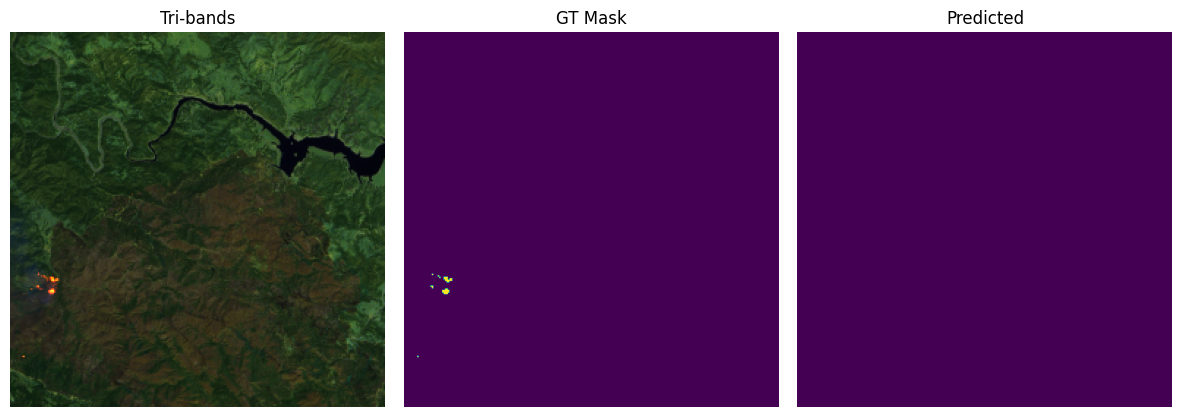

Image n 4, path : /content/sample_data/tribands/test/_Sentinel-2 L1C from 2016-09-25_Cloverdale_BANDS-S2-L1C_0_1.tif


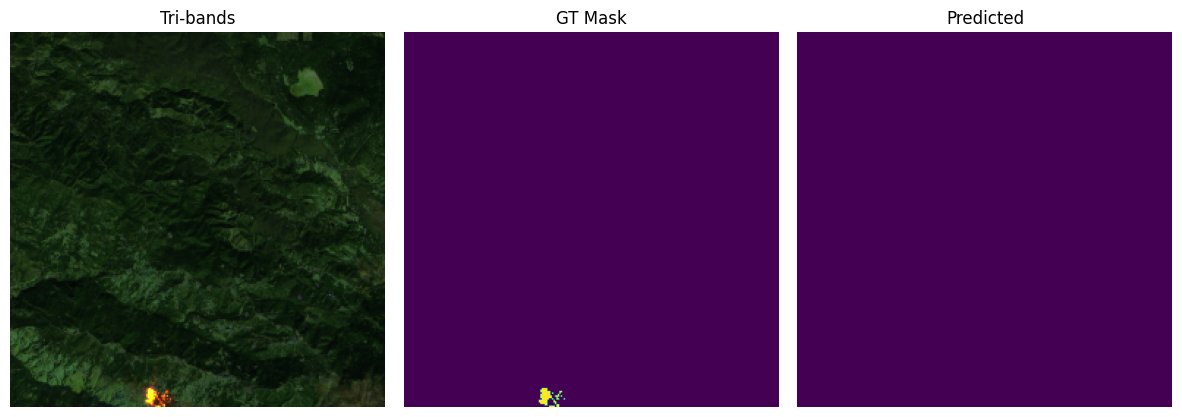

Image n 5, path : /content/sample_data/tribands/test/_Sentinel-2 L1C from 2017-07-24_ProençaANova_BANDS-S2-L1C_0_8.tif


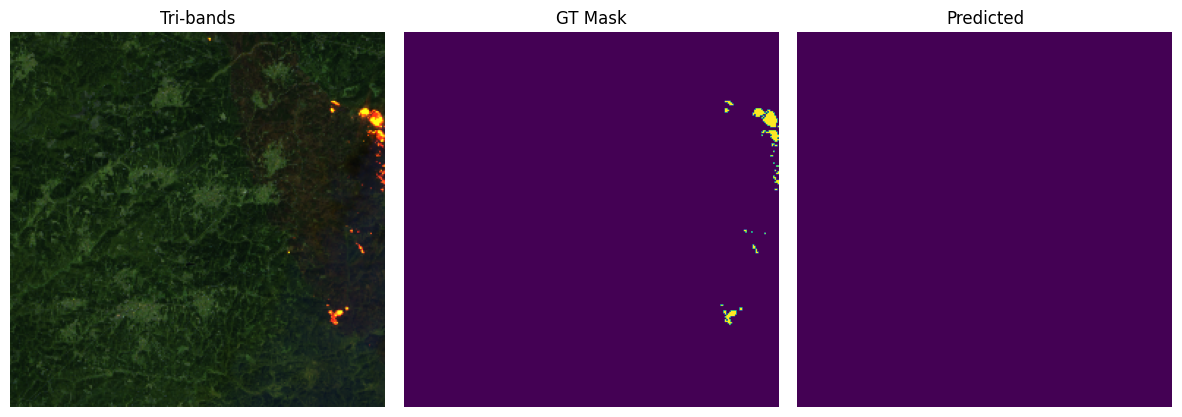

In [22]:
######################################
# Complete the folowing code replacing "______" :
######################################

# Diplay Tri-bands, mask and prediction of the model2
display_sample_prediction(model2, triband_img_paths_test, mask_img_paths_test)

######################################
######################################

### <font color="red">What do you think of the Predictions compared to the Masks ?</font>

**Put your answer bellow** :

De Thomas LOUIS : le modèle ne semble pas converger après plusieurs essaies sur des poids aléatoires...

Now we can check again the Confusion Matrix...

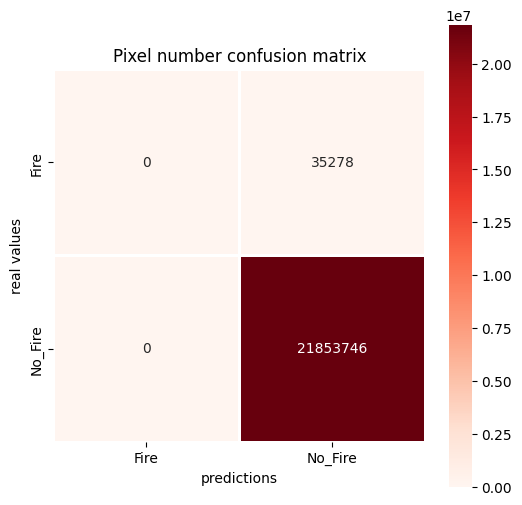

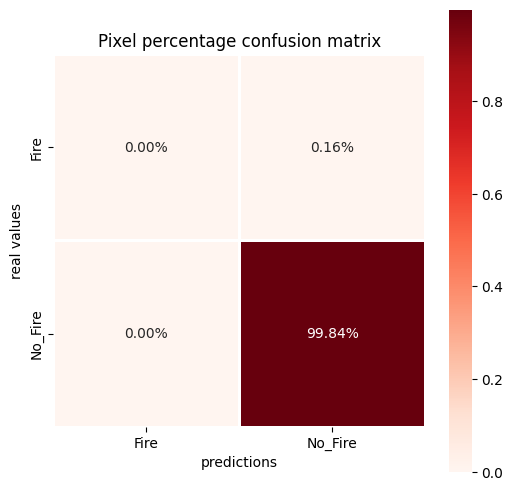

In [23]:
from utils import display_confusion_matrix, load_masks

# test_gt_masks = load_masks(mask_img_paths_test) # already load

display_confusion_matrix(predict(model2, test_ds), test_gt_masks)

### <font color="red">Compute Precision and Recall ?</font>

**Put your answer bellow** :

De Thomas LOUIS : le modèle ne semble pas converger après plusieurs essaies sur des poids aléatoires...

That's better, but can we improve the F1 score ? oui


# 3.1 Create and train the 3rd model

Let us clone the same Unet-like CNN model to test a new loss function...


In [24]:
model3 = clone_model(model)

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 4)       292       
                                                                 
 dropout (Dropout)           (None, 125, 125, 4)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 127, 127, 4)       148       
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 254, 254, 4)       0

# 3.2 Train with Dice/F-score loss
The Dice loss is a loss function commonly used in image segmentation tasks. It is a variation of the Sørensen-Dice coefficient, which is a measure of similarity between two sets.

The Dice loss calculates the difference between the predicted segmentation and the ground truth segmentation, with a range of 0 to 1, where 0 indicates no overlap and 1 indicates a perfect overlap.

The Dice loss is defined as 1 - (2 * (intersection of predicted and ground truth) / (size of predicted + size of ground truth)). Lower values of the Dice loss indicate a better match between the predicted and ground truth segmentations.

Bellow an implementation of the Dice loss function :

In [25]:
# The Dice loss function we will use in the model.compile
def dice_loss(y_true, y_pred):
    # Flatten the y_true and y_pred tensors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Calculate the intersection of y_true and y_pred
    intersection = K.sum(y_true_f * y_pred_f)

    # Return the Dice loss value
    return 1 - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


### <font color="red"> Compile model3 with the following parameters : </font>
 - An Adam optimizer with a learning rate at 0.01
 - The Dice loss created above
 - Several metrics :
   - Binary Accuracy
   - Recall
   - Precision
   - F1-score

In [26]:
# from metrics_and_losses import recall_m, precision_m, f1_m

######################################
# Complete the folowing code replacing "______" :
######################################
metrics = ['binary_accuracy', recall_m, precision_m, f1_m]

model3.compile(optimizer = Adam(0.01), metrics = metrics, loss = dice_loss)

######################################
######################################

Now we will train the model3 for 4 epochs with "train_ds" dataset for training and "val_ds" for validation.

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

history = model3.fit(train_ds, epochs = 4, validation_data = val_ds)

######################################
######################################

Epoch 1/4
64/64 [==============================] - 4s 32ms/step - loss: 0.9964 - binary_accuracy: 0.0182 - recall_m: 0.9837 - precision_m: 0.0018 - f1_m: 0.0035 - val_loss: 0.9975 - val_binary_accuracy: 0.0050 - val_recall_m: 0.9944 - val_precision_m: 0.0013 - val_f1_m: 0.0025
Epoch 2/4
64/64 [==============================] - 2s 27ms/step - loss: 0.9964 - binary_accuracy: 0.0341 - recall_m: 0.9719 - precision_m: 0.0018 - f1_m: 0.0035 - val_loss: 0.9975 - val_binary_accuracy: 0.0129 - val_recall_m: 0.9886 - val_precision_m: 0.0013 - val_f1_m: 0.0025
Epoch 3/4


Evaluate model3 with the test_ds dataset...

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

model3_score = model3.evaluate(test_ds)

######################################
######################################

# Display model1 scores
print_score(model3_score)

## Better results ?

Let's see if the model works better using a Dice loss. We can see that by displaying the predicted mask...

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

# Diplay Tri-bands, mask and prediction of the model3
display_sample_prediction(model3, triband_img_paths_test, mask_img_paths_test)

######################################
######################################

### <font color="red">What do you think of the Predictions compared to the Masks ?</font>

**Put your answer bellow** :

Let us check again the Confusion Matrix...

In [ ]:
from utils import display_confusion_matrix, load_masks

# test_gt_masks = load_masks(mask_img_paths_test) # already load

display_confusion_matrix(predict(model3, test_ds), test_gt_masks)

Finaly, let's try a combination of weighted loss and dice loss.

# 4.1 Create and train the 4th model

Let us clone the same Unet-like CNN model to test a combination of weighted loss and dice loss...


In [ ]:
model4 = clone_model(model)

model4.summary()

We define a loss function which combine a weighted binary crossentropy loss and a dice loss.

In [ ]:
def weighted_binary_crossentropy_and_dice(y_true, y_pred):
    return weighted_binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### <font color="red"> Compile model4 with the following parameters : </font>
 - An Adam optimizer with a learning rate at 0.01
 - The loss combination of weighted binary crossentropy and dice loss created above
 - Several metrics :
   - Binary Accuracy
   - Recall
   - Precision
   - F1-score

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

metrics = [______, ______, ______, ______]

______.compile(optimizer = ______, metrics = ______, loss = ______)

######################################
######################################

Now we will train the model4 for 4 epochs with "train_ds" dataset for trainong and "val_ds" for validation.

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

history = model4.fit(______, epochs = ______, validation_data = ______)

######################################
######################################

Evaluate model4 with the test_ds dataset...

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

model4_score = ______.evaluate(______)

######################################
######################################

# Display model1 scores
print_score(model4_score)

And display some prediction...

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

# Diplay Tri-bands, mask and prediction of the model4
display_sample_prediction(______, ______, ______)

######################################
######################################

### <font color="red">What do you think of the Predictions compared to the Masks ?</font>

**Put your answer bellow** :

Now we can check again the Confusion Matrix...

In [ ]:
from utils import display_confusion_matrix, load_masks

# test_gt_masks = load_masks(mask_img_paths_test) # already load

display_confusion_matrix(predict(model4, test_ds), test_gt_masks)

# 5.1 Compare all runs !

Write a code that print each scores of each runs using the function print_score(modelX_score) :

Don't forget to re-evaluate model1 with recall_m, precision_m, f1_m metrics

In [ ]:
######################################
# Complete the folowing code replacing "______" :
######################################

metrics = [______, ______, ______, ______]

______.compile(metrics = ______)
model1_score = ______.evaluate(______)


print("\n model1_score :")
...
print_score(model4_score)

######################################
######################################

#6. Bonus

Go to the Bonus_wildfire.ipynb Notebook.
If you have time left, try finding the best combination of loss/weight/epochs/architecture to get a test f1_score higher than 98%.